# BANA 274 Group 8 Final Project Code: Classifying Rotten Fruits

## Importing Packages

In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
import os
import random
import tensorflow as tf

from tabulate import tabulate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## Importing Dataset

In [ ]:
def load_images_from_folder(base_path, subfolder, label, max_images=3000):
    images = []
    labels = []

    # Ensure the folder path is accessible
    full_folder_path = os.path.join(base_path, subfolder)
    filenames = os.listdir(full_folder_path)
    random.shuffle(filenames)  # Shuffle the list of filenames
    for i, filename in enumerate(filenames):
        if i >= max_images:  # Stop after loading max_images
            break
        if filename.endswith('.DS_Store'):  # Skip .DS_Store files
            continue
        img_path = os.path.join(full_folder_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert all images to RGB
                img = img.resize((64, 64))  # Resize for uniformity
                images.append(np.array(img))
                labels.append(label)
        except IOError:
            print(f"Image at {img_path} could not be loaded.")
    return images, labels

# Dictionary to hold your folders and corresponding labels
folders = {
    'fresh': 1,
    'rotten': 0
}

X = []
Y = []
for subfolder, label in folders.items():
    images, labels = load_images_from_folder("dataset_new", subfolder, label)
    X.extend(images)
    Y.extend(labels)

X = np.array(X) # The X list contains all the images from the folders.
Y = np.array(Y) # The Y list contains the corresponding labels.

In [ ]:
from sklearn.model_selection import train_test_split

# Test set (X_test and Y_test): After all training and validation is complete, the model's performance is evaluated one final time on the test set.
X1, X_test, Y1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train set (X_train and Y_train): The sample of data used to fit the model.
# Cross-validation set (X_cv and Y_cv): After the model has been trained on the training data, it's tested on the cross-validation data.
X_train, X_cv, Y_train, Y_cv = train_test_split(X1, Y1, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Count the number of observations with an outcome of zero
num_zeros = np.count_nonzero(Y == 0)
# Count the number of observations with an outcome of one
num_ones = np.count_nonzero(Y == 1)



# Reporting the number of examples in each set
print(f"Total observation: {len(X)}")
print(f"Number of observations with an outcome of 0: {num_zeros}")
print(f"Number of observations with an outcome of 1: {num_ones}")

print(f"Training set: {len(X_train)} examples")
print(f"Cross-validation set: {len(X_cv)} examples")
print(f"Test set: {len(X_test)} examples")

Total observation: 4179
Number of observations with an outcome of 0: 2241
Number of observations with an outcome of 1: 1938
Training set: 2507 examples
Cross-validation set: 836 examples
Test set: 836 examples


In [ ]:
# Reshape the training, cv, and test examples
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T  # The "-1" makes reshape flatten the remaining dimensions
X_cv_flatten = X_cv.reshape(X_cv.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train = X_train_flatten / 255.
X_cv = X_cv_flatten / 255.
X_test = X_test_flatten / 255.

print("X_train's shape: " + str(X_train.shape))
print("X_cv's shape: " + str(X_cv.shape))
print("X_test's shape: " + str(X_test.shape))


X_train's shape: (12288, 2507)
X_cv's shape: (12288, 836)
X_test's shape: (12288, 836)


In [ ]:
# Reshape
Y_train = Y_train.reshape(1, -1).T
Y_cv = Y_cv.reshape(1, -1).T
Y_test = Y_test.reshape(1, -1).T

print ("Y_train's shape: " + str(Y_train.shape))
print ("Y_cv's shape: " + str(Y_cv.shape))
print ("Y_test's shape: " + str(Y_test.shape))

Y_train's shape: (2507, 1)
Y_cv's shape: (836, 1)
Y_test's shape: (836, 1)


## NN Model Without Tensorflow

### NN Model without Optimization

In [ ]:
### CONSTANTS ###
n_x = 12288  # num_px * num_px * 3
n_h_1 = 7
n_h_2 = 4
n_y = 1
layers_dims = [n_x, n_h_1, n_h_2, n_y]

In [ ]:
# L_layer_model implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
# X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
# Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
# layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
# learning_rate -- learning rate of the gradient descent update rule
# num_iterations -- number of iterations of the optimization loop
# print_cost -- if True, it prints the cost every 100 steps
# this function returns: parameters -- parameters learnt by the model. They can then be used to predict.

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations= 1000,  print_cost=False):
    costs = [] # keep track of cost
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims) # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters) # Compute cost.
        cost = compute_cost(AL, Y) # Backward propagation.
        grads = L_model_backward(AL, Y, caches) # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0: costs.append(cost)

    if print_cost:
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters

### NN Model with Random Search

In [ ]:
# Updated predict function to only returns accuracy
def predict(X, y, parameters):
    m = X.shape[1] # Number of examples
    p = np.zeros((1, m))
    AL, caches = L_model_forward(X, parameters)
    p = (AL > 0.5)
    accuracy = np.sum((p == y) / m) # Compute the accuracy
    return accuracy


# Define the function for random search
def random_search(X_train, Y_train, X_cv, Y_cv, n_iter=25):
    best_alpha = None
    best_n1 = None
    best_accuracy = 0
    for i in range(n_iter):
        alpha = 10 ** np.random.uniform(-3, 1)
        n1 = np.random.randint(2, 50)
        layers_dims = [X_train.shape[0], n1, 4, 1] # Updated layers_dims with random n1
        parameters = L_layer_model(X_train, Y_train, layers_dims, learning_rate=alpha, num_iterations=1000, print_cost=False)
        accuracy = predict(X_cv, Y_cv, parameters)

        print(f"Iteration {i+1}: alpha = {alpha}, n1 = {n1}, CV accuracy = {accuracy}")

        if accuracy > best_accuracy:
            best_alpha = alpha
            best_n1 = n1
            best_accuracy = accuracy
    return best_alpha, best_n1, best_accuracy

In [ ]:
# Run the random search
best_alpha, best_n1, best_accuracy = random_search(X_train, Y_train, X_cv, Y_cv, n_iter=25)

Iteration 1: alpha = 2.6181293023584824, n1 = 2, CV accuracy = 0.47916666666666663
Iteration 2: alpha = 0.91532884587949, n1 = 29, CV accuracy = 0.47916666666666663
Iteration 3: alpha = 0.05474978669422397, n1 = 47, CV accuracy = 0.8041666666666666
Iteration 4: alpha = 4.850794695931797, n1 = 44, CV accuracy = 0.47916666666666663
Iteration 5: alpha = 0.001775922218241654, n1 = 6, CV accuracy = 0.8145833333333332
Iteration 6: alpha = 0.24350182050056596, n1 = 2, CV accuracy = 0.47916666666666663
Iteration 7: alpha = 0.91532884587949, n1 = 29, CV accuracy = 0.47916666666666663
Iteration 8: alpha = 0.05474978669422397, n1 = 47, CV accuracy = 0.8041666666666666
Iteration 9: alpha = 4.850794695931797, n1 = 44, CV accuracy = 0.47916666666666663
Iteration 10: alpha = 0.001775922218241654, n1 = 6, CV accuracy = 0.8145833333333332
Iteration 11: alpha = 0.24350182050056596, n1 = 2, CV accuracy = 0.47916666666666663
Iteration 12: alpha = 0.91532884587949, n1 = 29, CV accuracy = 0.4791666666666666

In [ ]:
# Find best aloha, number of n1, and the best CV accuracy

print(f"Best alpha: {best_alpha}, Best n1: {best_n1}, Best CV accuracy: {best_accuracy}")

# Train the final model with the best hyperparameters
layers_dims = [X_train.shape[0], best_n1, 4, 1]
parameters = L_layer_model(X_train, Y_train, layers_dims, learning_rate= best_alpha, num_iterations=2500, print_cost=False)

# Evaluate on the train set
train_accuracy = predict(X_train, Y_train, parameters)
print("Train accuracy: ", train_accuracy)

Best alpha: 0.001775922218241654, Best n1: 6, Best CV accuracy: 0.8145833333333332
Train accuracy:  0.89375


## Tensorflow Model

**Recall our best NN model parameters**

n_x = 12288     # Input layer size

best_n1 = 6     # Number of units in the first hidden layer

n_h2 = 4        # Number of units in the second hidden layer

n_y =  1        # Output layer size

Best alpha: 0.001775922218241654  

Best CV accuracy: 0.8145833333333332

Train accuracy: 0.89375

### Comparing Different Optimization Algorithms

#### Model 1- Adam

In [ ]:
X_train = X_train.T
X_cv = X_cv.T
X_test = X_test.T

In [ ]:
# Adam

Adam_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

Adam_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

# model.summary()

history = Adam_model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 2)

Epoch 1/25
79/79 - 1s - 12ms/step - binary_accuracy: 0.5010 - loss: 0.8661
Epoch 2/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6916
Epoch 3/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6904
Epoch 4/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6896
Epoch 5/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6893
Epoch 6/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6891
Epoch 7/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6889
Epoch 8/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6889
Epoch 9/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 10/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 11/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 12/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 13/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 14/25
79/79 - 0s - 1ms/step

In [ ]:
test_loss, test_accuracy = Adam_model.evaluate(X_test, Y_test)
print("Accracy: ", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - binary_accuracy: 0.4951 - loss: 0.6983
Accracy:  0.5


#### Model 2- RMSprop

In [ ]:
# RMSprop

RMSprop_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

RMSprop_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

# model.summary()

history = RMSprop_model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 2)

Epoch 1/25
79/79 - 1s - 8ms/step - binary_accuracy: 0.5245 - loss: 0.7648
Epoch 2/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6918
Epoch 3/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6903
Epoch 4/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6895
Epoch 5/25
79/79 - 0s - 3ms/step - binary_accuracy: 0.5469 - loss: 0.6892
Epoch 6/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6890
Epoch 7/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6889
Epoch 8/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 9/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 10/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 11/25
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 12/25
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 13/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.5469 - loss: 0.6888
Epoch 14/25
79/79 - 0s - 1ms/step 

In [ ]:
test_loss, test_accuracy = RMSprop_model.evaluate(X_test, Y_test)
print("Accracy: ", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.4951 - loss: 0.6984
Accracy:  0.5


#### Model 3- SDG

In [ ]:
# SDG

SGD_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

SGD_model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

# model.summary()

history = SGD_model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 2)

Epoch 1/25
79/79 - 0s - 4ms/step - binary_accuracy: 0.5552 - loss: 0.6905
Epoch 2/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6478 - loss: 0.6333
Epoch 3/25
79/79 - 0s - 948us/step - binary_accuracy: 0.7052 - loss: 0.5921
Epoch 4/25
79/79 - 0s - 965us/step - binary_accuracy: 0.7176 - loss: 0.5621
Epoch 5/25
79/79 - 0s - 967us/step - binary_accuracy: 0.7343 - loss: 0.5388
Epoch 6/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7447 - loss: 0.5229
Epoch 7/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7531 - loss: 0.5048
Epoch 8/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7539 - loss: 0.4893
Epoch 9/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7591 - loss: 0.4735
Epoch 10/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7527 - loss: 0.4776
Epoch 11/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7722 - loss: 0.4587
Epoch 12/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7698 - loss: 0.4547
Epoch 13/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7635 - loss: 0.4533
Epoch 14/25
79/79 - 0s - 1ms

In [ ]:
test_loss, test_accuracy = SGD_model.evaluate(X_test, Y_test)
print("Accracy: ", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - binary_accuracy: 0.7600 - loss: 0.4564
Accracy:  0.7643540501594543


#### Model 4- Adadelta

In [ ]:
# Adadelta

Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

# model.summary()

history = Adadelta_model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 2)

Epoch 1/25
79/79 - 1s - 9ms/step - binary_accuracy: 0.5983 - loss: 0.6738
Epoch 2/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6338 - loss: 0.6571
Epoch 3/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6546 - loss: 0.6497
Epoch 4/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6633 - loss: 0.6437
Epoch 5/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6689 - loss: 0.6380
Epoch 6/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6813 - loss: 0.6326
Epoch 7/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6865 - loss: 0.6277
Epoch 8/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.6925 - loss: 0.6226
Epoch 9/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7000 - loss: 0.6187
Epoch 10/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7024 - loss: 0.6139
Epoch 11/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7072 - loss: 0.6096
Epoch 12/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7036 - loss: 0.6055
Epoch 13/25
79/79 - 0s - 1ms/step - binary_accuracy: 0.7124 - loss: 0.6013
Epoch 14/25
79/79 - 0s - 1ms/step 

In [ ]:
test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Accuracy: ", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - binary_accuracy: 0.7513 - loss: 0.5510
Accuracy:  0.7643540501594543


#### **Conclusion of Optimization Algorithms**
| Optimization Algorithms | Training Performance | Testing Performance |
|----------|----------|----------|
| Adam | 49.51 % | 50.00 % |
| RMSprop | 49.51 % | 50.00 % |
| SDG | 76.00 % | 76.35 % |  
| Adadelta | 75.13 % | 76.43 % |

Adadelta is the best optimization algorithmn in our run as it provides the highest training and testing performance.

### Comparing Different Model Structure, L2 Regularization, Dropout, and Early Stopping

#### Changing NN Model Structure

In [ ]:
# Changing structure of the model from 6 hidden units to 20

Adadelta_model = Sequential([
                    Dense(20, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 14ms/step - binary_accuracy: 0.4535 - loss: 0.6933 - val_binary_accuracy: 0.4569 - val_loss: 0.6932
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4547 - loss: 0.6933 - val_binary_accuracy: 0.4522 - val_loss: 0.6932
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4555 - loss: 0.6932 - val_binary_accuracy: 0.4581 - val_loss: 0.6932
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4559 - loss: 0.6932 - val_binary_accuracy: 0.4581 - val_loss: 0.6931
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4631 - loss: 0.6932 - val_binary_accuracy: 0.4725 - val_loss: 0.6931
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4679 - loss: 0.6931 - val_binary_accuracy: 0.4880 - val_loss: 0.6931
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4882 - loss: 0.6931 - val_binary_accuracy: 0.5048 - val_loss: 0.6931
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5030 - loss: 0.6931 - val_binary_accuracy: 0.5203 - val_loss: 0.6930
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - binary_accuracy: 0.5520 - loss: 0.6910
Train Accuracy:  0.5468687415122986 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - binary_accuracy: 0.5224 - loss: 0.6918
CV Accuracy:  0.540669858455658 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - binary_accuracy: 0.4951 - loss: 0.6923
Test Accuracy:  0.5 



#### Implement L2 regularization  (Using penalty weight = 0.001)

In [ ]:
# Adam

Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,), kernel_regularizer = regularizers.l2(0.001)),
                    Dense(4, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
                    Dense(1, activation = 'sigmoid', kernel_regularizer = regularizers.l2(0.001))
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 12ms/step - binary_accuracy: 0.5457 - loss: 0.7124 - val_binary_accuracy: 0.5467 - val_loss: 0.7106
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5461 - loss: 0.7107 - val_binary_accuracy: 0.5455 - val_loss: 0.7100
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5473 - loss: 0.7101 - val_binary_accuracy: 0.5455 - val_loss: 0.7095
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5441 - loss: 0.7097 - val_binary_accuracy: 0.5467 - val_loss: 0.7091
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5441 - loss: 0.7084 - val_binary_accuracy: 0.5431 - val_loss: 0.7086
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5429 - loss: 0.7052 - val_binary_accuracy: 0.5443 - val_loss: 0.7057
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5457 - loss: 0.7011 - val_binary_accuracy: 0.5431 - val_loss: 0.7020
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6960 - val_binary_accuracy: 0.5407 - val_loss: 0.6995
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - binary_accuracy: 0.7543 - loss: 0.5547
Train Accuracy:  0.755883514881134 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - binary_accuracy: 0.7196 - loss: 0.5825
CV Accuracy:  0.7284688949584961 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - binary_accuracy: 0.6861 - loss: 0.5806
Test Accuracy:  0.7177033424377441 



#### Implement Dropout Regularization (Using dropout rate of 0.5)

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dropout(0.5),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 10ms/step - binary_accuracy: 0.5572 - loss: 0.6892 - val_binary_accuracy: 0.5610 - val_loss: 0.6825
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5684 - loss: 0.6835 - val_binary_accuracy: 0.5730 - val_loss: 0.6792
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5760 - loss: 0.6768 - val_binary_accuracy: 0.5837 - val_loss: 0.6748
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5812 - loss: 0.6753 - val_binary_accuracy: 0.5861 - val_loss: 0.6726
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5756 - loss: 0.6755 - val_binary_accuracy: 0.6065 - val_loss: 0.6687
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5708 - loss: 0.6726 - val_binary_accuracy: 0.6005 - val_loss: 0.6670
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5708 - loss: 0.6741 - val_binary_accuracy: 0.5825 - val_loss: 0.6675
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5991 - loss: 0.6681 - val_binary_accuracy: 0.6148 - val_loss: 0.6626
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - binary_accuracy: 0.8144 - loss: 0.5160
Train Accuracy:  0.8165137767791748 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - binary_accuracy: 0.7640 - loss: 0.5371
CV Accuracy:  0.7739234566688538 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - binary_accuracy: 0.7854 - loss: 0.5293
Test Accuracy:  0.8062201142311096 



#### Implement Early Stopping (Using min_delta of 0.02 and patience of 10.)

In [ ]:
#set early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10)

Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    Dropout(0.5),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))


Epoch 1/100
79/79 - 1s - 10ms/step - binary_accuracy: 0.4675 - loss: 0.7145 - val_binary_accuracy: 0.4474 - val_loss: 0.6990
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4826 - loss: 0.6991 - val_binary_accuracy: 0.4533 - val_loss: 0.6965
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5054 - loss: 0.6960 - val_binary_accuracy: 0.4617 - val_loss: 0.6952
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5046 - loss: 0.6945 - val_binary_accuracy: 0.4462 - val_loss: 0.6949
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5166 - loss: 0.6946 - val_binary_accuracy: 0.4713 - val_loss: 0.6945
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4866 - loss: 0.6943 - val_binary_accuracy: 0.4749 - val_loss: 0.6939
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4942 - loss: 0.6941 - val_binary_accuracy: 0.4988 - val_loss: 0.6932
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5134 - loss: 0.6931 - val_binary_accuracy: 0.5550 - val_loss: 0.6901
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - binary_accuracy: 0.8179 - loss: 0.5759
Train Accuracy:  0.8105305433273315 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - binary_accuracy: 0.7931 - loss: 0.5813
CV Accuracy:  0.7870813608169556 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - binary_accuracy: 0.7999 - loss: 0.5806
Test Accuracy:  0.8014354109764099 



#### **Conclusion**
| Change | Training Accuracy | Validation Accuracy | Test Accuracy |
|-----------------------|-------------------|---------------------|---------------|
| NN Structure       |    54.69 %       |   54.07 %     | 50.00 %
| L2 Regularization      |      75.58 %      |       72.84 %        |     71.77 %     |
| Dropout Regularization   |       81.65 %       |        77.39 %        |     80.62 %     |
| Early Stopping            |       81.05 %       |        78.71 %        |     80.14 %     |

When enhanced with early stopping, original model achieves greater accuracy improvements compared to other modifications

### Comparing Different Weight Initializations

#### Weight Initialization- random_uniform

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,), kernel_initializer='random_uniform', bias_initializer=Constant(0.01)),
                    Dropout(0.5),
                    Dense(4, activation = 'relu', kernel_initializer='random_uniform', bias_initializer=Constant(0.01)),
                    Dense(1, activation = 'sigmoid', kernel_initializer='random_uniform')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)



# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 19ms/step - binary_accuracy: 0.4531 - loss: 0.6932 - val_binary_accuracy: 0.4593 - val_loss: 0.6932
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4531 - loss: 0.6932 - val_binary_accuracy: 0.4593 - val_loss: 0.6931
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.4695 - loss: 0.6931 - val_binary_accuracy: 0.5371 - val_loss: 0.6931
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5389 - loss: 0.6931 - val_binary_accuracy: 0.5407 - val_loss: 0.6931
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6931 - val_binary_accuracy: 0.5407 - val_loss: 0.6931
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6931 - val_binary_accuracy: 0.5407 - val_loss: 0.6931
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6931 - val_binary_accuracy: 0.5407 - val_loss: 0.6931
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5469 - loss: 0.6931 - val_binary_accuracy: 0.5407 - val_loss: 0.6931
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - binary_accuracy: 0.5520 - loss: 0.6928
Train Accuracy:  0.5468687415122986 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - binary_accuracy: 0.5224 - loss: 0.6930
CV Accuracy:  0.540669858455658 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - binary_accuracy: 0.4951 - loss: 0.6932
Test Accuracy:  0.5 



#### Weight Initialization- he_uniform for kernerl_initializer and constant bias_initializer

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,), kernel_initializer='he_uniform', bias_initializer=Constant(0.01)),
                    Dropout(0.5),
                    Dense(4, activation = 'relu', kernel_initializer='he_uniform', bias_initializer=Constant(0.01)),
                    Dense(1, activation = 'sigmoid', kernel_initializer='he_uniform')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)



# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))



Epoch 1/100
79/79 - 2s - 20ms/step - binary_accuracy: 0.5142 - loss: 0.6948 - val_binary_accuracy: 0.4940 - val_loss: 0.6913
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5345 - loss: 0.6918 - val_binary_accuracy: 0.5335 - val_loss: 0.6902
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5309 - loss: 0.6917 - val_binary_accuracy: 0.5622 - val_loss: 0.6900
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5329 - loss: 0.6906 - val_binary_accuracy: 0.5658 - val_loss: 0.6895
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5349 - loss: 0.6911 - val_binary_accuracy: 0.5766 - val_loss: 0.6889
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5576 - loss: 0.6866 - val_binary_accuracy: 0.5191 - val_loss: 0.6877
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5588 - loss: 0.6877 - val_binary_accuracy: 0.5419 - val_loss: 0.6861
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5309 - loss: 0.6881 - val_binary_accuracy: 0.5574 - val_loss: 0.6852
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - binary_accuracy: 0.7652 - loss: 0.5421
Train Accuracy:  0.7742321491241455 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - binary_accuracy: 0.7392 - loss: 0.5547
CV Accuracy:  0.7535884976387024 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - binary_accuracy: 0.7694 - loss: 0.5487
Test Accuracy:  0.7763158082962036 



#### Weight Initialization- Orthogonal

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,), kernel_initializer='orthogonal', bias_initializer=Constant(0.01)),
                    Dropout(0.5),
                    Dense(4, activation = 'relu', kernel_initializer='orthogonal', bias_initializer=Constant(0.01)),
                    Dense(1, activation = 'sigmoid', kernel_initializer='orthogonal')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)



# model.summary()
history = Adadelta_model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 13ms/step - binary_accuracy: 0.5066 - loss: 0.6866 - val_binary_accuracy: 0.5742 - val_loss: 0.6770
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5181 - loss: 0.6811 - val_binary_accuracy: 0.5969 - val_loss: 0.6736
Epoch 3/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.5213 - loss: 0.6759 - val_binary_accuracy: 0.5933 - val_loss: 0.6682
Epoch 4/100
79/79 - 0s - 4ms/step - binary_accuracy: 0.5481 - loss: 0.6658 - val_binary_accuracy: 0.6160 - val_loss: 0.6592
Epoch 5/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.5540 - loss: 0.6665 - val_binary_accuracy: 0.6208 - val_loss: 0.6548
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5756 - loss: 0.6607 - val_binary_accuracy: 0.6687 - val_loss: 0.6504
Epoch 7/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.5708 - loss: 0.6585 - val_binary_accuracy: 0.6639 - val_loss: 0.6443
Epoch 8/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.5736 - loss: 0.6548 - val_binary_accuracy: 0.6866 - val_loss: 0.6413
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - binary_accuracy: 0.8039 - loss: 0.4982
Train Accuracy:  0.8061428070068359 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - binary_accuracy: 0.7685 - loss: 0.5186
CV Accuracy:  0.7739234566688538 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - binary_accuracy: 0.7872 - loss: 0.5117
Test Accuracy:  0.7894737124443054 



#### **Conclusion of Weight Initializations**
| Change | Training Accuracy | Validation Accuracy | Test Accuracy |
|-----------------------|-------------------|---------------------|---------------|  
| Random Uniform        |       54.69 %       |        54.07 %        |     50.00 %     |
| He Uniform            |       77.42 %       |        75.35 %        |     77.63 %     |
| Orthogonal            |       80.61 %       |        77.39 %        |     78.94 %     |

It seems that changing weight initialization doesn't improve the original model compared to early stopping and dropout.

### Comparing Batch Normalizations

#### Standard Batch Normalization

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(),
                    Dense(4, activation = 'relu'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history = Adadelta_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 18ms/step - binary_accuracy: 0.6502 - loss: 0.6429 - val_binary_accuracy: 0.5407 - val_loss: 0.6920
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6877 - loss: 0.6089 - val_binary_accuracy: 0.5407 - val_loss: 0.6904
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7056 - loss: 0.5863 - val_binary_accuracy: 0.5407 - val_loss: 0.6875
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7268 - loss: 0.5705 - val_binary_accuracy: 0.5443 - val_loss: 0.6821
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7359 - loss: 0.5564 - val_binary_accuracy: 0.5634 - val_loss: 0.6723
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7531 - loss: 0.5436 - val_binary_accuracy: 0.6423 - val_loss: 0.6537
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7535 - loss: 0.5320 - val_binary_accuracy: 0.7404 - val_loss: 0.6213
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7571 - loss: 0.5246 - val_binary_accuracy: 0.7560 - val_loss: 0.5831
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - binary_accuracy: 0.9140 - loss: 0.3272
Train Accuracy:  0.9206222295761108 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - binary_accuracy: 0.9017 - loss: 0.3465
CV Accuracy:  0.9031100273132324 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - binary_accuracy: 0.8940 - loss: 0.3492
Test Accuracy:  0.8911483287811279 



#### Custom Momentum

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(momentum=0.9),
                    Dense(4, activation = 'relu'),
                    BatchNormalization(momentum=0.9),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history = Adadelta_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 2s - 22ms/step - binary_accuracy: 0.5760 - loss: 0.6803 - val_binary_accuracy: 0.6208 - val_loss: 0.6435
Epoch 2/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.6334 - loss: 0.6373 - val_binary_accuracy: 0.6722 - val_loss: 0.6064
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6669 - loss: 0.6086 - val_binary_accuracy: 0.6974 - val_loss: 0.5770
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6837 - loss: 0.5828 - val_binary_accuracy: 0.7057 - val_loss: 0.5586
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7044 - loss: 0.5629 - val_binary_accuracy: 0.7153 - val_loss: 0.5408
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7256 - loss: 0.5447 - val_binary_accuracy: 0.7321 - val_loss: 0.5260
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7224 - loss: 0.5290 - val_binary_accuracy: 0.7476 - val_loss: 0.5112
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7347 - loss: 0.5172 - val_binary_accuracy: 0.7512 - val_loss: 0.5004
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - binary_accuracy: 0.8426 - loss: 0.4015
Train Accuracy:  0.8464300036430359 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - binary_accuracy: 0.7984 - loss: 0.4531
CV Accuracy:  0.8026315569877625 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - binary_accuracy: 0.8084 - loss: 0.4374
Test Accuracy:  0.820574164390564 



#### Custom Epsilon

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(epsilon=1e-5),
                    Dense(4, activation = 'relu'),
                    BatchNormalization(epsilon=1e-5),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


history = Adadelta_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 15ms/step - binary_accuracy: 0.5919 - loss: 0.7520 - val_binary_accuracy: 0.5443 - val_loss: 0.6864
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6139 - loss: 0.7180 - val_binary_accuracy: 0.6029 - val_loss: 0.6852
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6410 - loss: 0.6791 - val_binary_accuracy: 0.6352 - val_loss: 0.6607
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6382 - loss: 0.6650 - val_binary_accuracy: 0.6495 - val_loss: 0.6361
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6498 - loss: 0.6532 - val_binary_accuracy: 0.6651 - val_loss: 0.6305
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6669 - loss: 0.6260 - val_binary_accuracy: 0.6711 - val_loss: 0.6447
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6673 - loss: 0.6130 - val_binary_accuracy: 0.6675 - val_loss: 0.6359
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6785 - loss: 0.6072 - val_binary_accuracy: 0.6663 - val_loss: 0.6204
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - binary_accuracy: 0.8194 - loss: 0.4070
Train Accuracy:  0.8276824951171875 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - binary_accuracy: 0.7744 - loss: 0.4617
CV Accuracy:  0.7763158082962036 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - binary_accuracy: 0.7917 - loss: 0.4627
Test Accuracy:  0.7894737124443054 



#### Custom Beta and Gamma Initializer

In [ ]:
Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(beta_initializer='he_normal', gamma_initializer='he_normal'),
                    Dense(4, activation = 'relu'),
                    BatchNormalization(beta_initializer='he_normal', gamma_initializer='he_normal'),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)


history = Adadelta_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 1s - 14ms/step - binary_accuracy: 0.5892 - loss: 0.6854 - val_binary_accuracy: 0.5957 - val_loss: 0.6747
Epoch 2/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6227 - loss: 0.6503 - val_binary_accuracy: 0.6100 - val_loss: 0.6526
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6454 - loss: 0.6305 - val_binary_accuracy: 0.6507 - val_loss: 0.6243
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6749 - loss: 0.6140 - val_binary_accuracy: 0.6842 - val_loss: 0.5993
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6925 - loss: 0.5947 - val_binary_accuracy: 0.6962 - val_loss: 0.5817
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7048 - loss: 0.5877 - val_binary_accuracy: 0.7033 - val_loss: 0.5695
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7128 - loss: 0.5758 - val_binary_accuracy: 0.7093 - val_loss: 0.5563
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.7327 - loss: 0.5637 - val_binary_accuracy: 0.7225 - val_loss: 0.5465
Epoch 9

In [ ]:
# Get the accuracies
train_loss, train_accuracy = Adadelta_model.evaluate(X_train, Y_train)
print("Train Accuracy: ", train_accuracy, "\n")

cv_loss, cv_accuracy = Adadelta_model.evaluate(X_cv, Y_cv)
print("CV Accuracy: ", cv_accuracy, "\n")

test_loss, test_accuracy = Adadelta_model.evaluate(X_test, Y_test)
print("Test Accuracy: ", test_accuracy, "\n")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - binary_accuracy: 0.8390 - loss: 0.3961
Train Accuracy:  0.8416433930397034 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - binary_accuracy: 0.7973 - loss: 0.4230
CV Accuracy:  0.8133971095085144 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - binary_accuracy: 0.7913 - loss: 0.4408
Test Accuracy:  0.8050239086151123 



#### **Conclusion of Batch Normalizations**
| Change | Training Accuracy | Validation Accuracy | Test Accuracy |
|-----------------------|-------------------|---------------------|---------------|
| Batch Normalization                 |       92.06 %      |        90.31 %        |     89.11 %     |
| Custom Momentum                  |       84.64 %        |        80.62 %        |     82.06 %     |
| Custom Epsilon                     |       82.67 %         |        77.63 %        |     78.94 %     |
| Custom Beta & Gamma Initializer |       84.16 %         |        81.33 %        |     80.50 %     |


The model with standard batch normalization presents the best accuracy so far.

### Saving Model Checkpoints

In [ ]:
X_train = X_train.T
X_cv = X_cv.T
X_test = X_test.T

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_cv:", X_cv.shape)
print("Shape of X_cv:", Y_cv.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_test:", Y_test.shape)

Shape of X_train: (2507, 12288)
Shape of Y_train: (2507, 1)
Shape of X_cv: (836, 12288)
Shape of X_cv: (836, 1)
Shape of X_test: (836, 12288)
Shape of X_test: (836, 1)


In [ ]:
# Using our best model so far: Standard Batch Normalization

# Create a checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_Adadelta_model.keras', monitor='val_loss', save_best_only=True, mode='min')

Adadelta_model = Sequential([
                    Dense(6, activation = 'relu', input_shape = (12288,)),
                    BatchNormalization(),
                    Dense(4, activation = 'relu'),
                    BatchNormalization(),
                    Dense(1, activation = 'sigmoid')
])

Adadelta_model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history = Adadelta_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv), callbacks=[checkpoint_callback])

Adadelta_model.save_weights('best_model.h5')

Epoch 1/100
79/79 - 1s - 15ms/step - binary_accuracy: 0.4739 - loss: 0.7188 - val_binary_accuracy: 0.4629 - val_loss: 0.7173
Epoch 2/100
79/79 - 0s - 3ms/step - binary_accuracy: 0.5082 - loss: 0.7107 - val_binary_accuracy: 0.4916 - val_loss: 0.7109
Epoch 3/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5365 - loss: 0.7041 - val_binary_accuracy: 0.5179 - val_loss: 0.7048
Epoch 4/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5652 - loss: 0.6977 - val_binary_accuracy: 0.5730 - val_loss: 0.6983
Epoch 5/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.5919 - loss: 0.6916 - val_binary_accuracy: 0.5981 - val_loss: 0.6924
Epoch 6/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6239 - loss: 0.6854 - val_binary_accuracy: 0.6196 - val_loss: 0.6864
Epoch 7/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6426 - loss: 0.6795 - val_binary_accuracy: 0.6268 - val_loss: 0.6806
Epoch 8/100
79/79 - 0s - 2ms/step - binary_accuracy: 0.6502 - loss: 0.6736 - val_binary_accuracy: 0.6352 - val_loss: 0.6759
Epoch 9

### CNN model

In [ ]:
X_train = X_train.reshape(-1, 64, 64, 3)
X_cv = X_cv.reshape(-1, 64, 64, 3)
X_test = X_test.reshape(-1, 64, 64, 3)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_cv:", X_cv.shape)
print("Shape of X_cv:", Y_cv.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_test:", Y_test.shape)

Shape of X_train: (2507, 64, 64, 3)
Shape of Y_train: (2507, 1)
Shape of X_cv: (836, 64, 64, 3)
Shape of X_cv: (836, 1)
Shape of X_test: (836, 64, 64, 3)
Shape of X_test: (836, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# CNN Model

cnn_model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
                MaxPooling2D(pool_size=(2, 2)),

                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D(pool_size=(2, 2)),

                Flatten(),

                # Dense Layers (similar to the original model but adjusted)
                Dense(128, activation='relu'),
                Dense(1, activation='sigmoid')
])


# Compile the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.001775922218241654),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Train the model with the checkpoint callback
cnn_history = cnn_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_cv, Y_cv))

Epoch 1/100
79/79 - 5s - 66ms/step - binary_accuracy: 0.5536 - loss: 0.6868 - val_binary_accuracy: 0.5526 - val_loss: 0.6831
Epoch 2/100
79/79 - 7s - 91ms/step - binary_accuracy: 0.5951 - loss: 0.6779 - val_binary_accuracy: 0.5682 - val_loss: 0.6751
Epoch 3/100
79/79 - 7s - 93ms/step - binary_accuracy: 0.6155 - loss: 0.6702 - val_binary_accuracy: 0.5849 - val_loss: 0.6686
Epoch 4/100
79/79 - 7s - 85ms/step - binary_accuracy: 0.6302 - loss: 0.6641 - val_binary_accuracy: 0.6292 - val_loss: 0.6625
Epoch 5/100
79/79 - 7s - 85ms/step - binary_accuracy: 0.6761 - loss: 0.6579 - val_binary_accuracy: 0.5909 - val_loss: 0.6583
Epoch 6/100
79/79 - 6s - 78ms/step - binary_accuracy: 0.6745 - loss: 0.6525 - val_binary_accuracy: 0.6100 - val_loss: 0.6525
Epoch 7/100
79/79 - 7s - 95ms/step - binary_accuracy: 0.6881 - loss: 0.6466 - val_binary_accuracy: 0.6770 - val_loss: 0.6457
Epoch 8/100
79/79 - 8s - 96ms/step - binary_accuracy: 0.7084 - loss: 0.6405 - val_binary_accuracy: 0.6770 - val_loss: 0.6406


In [ ]:
# Save the CNN model architecture and weights
cnn_model.save_weights('cnn_model.h5')

In [ ]:
import pandas as pd

df = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

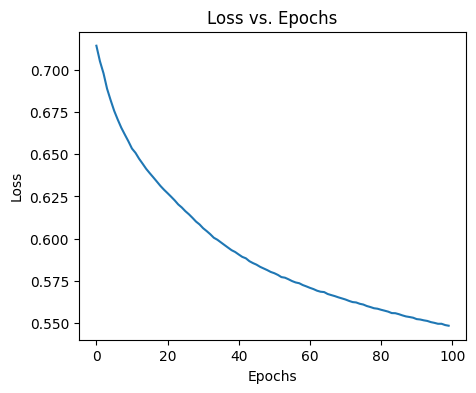

In [ ]:
# Make a plot for the loss

loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

In [ ]:
print(history.history.keys())

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'binary_accuracy')]

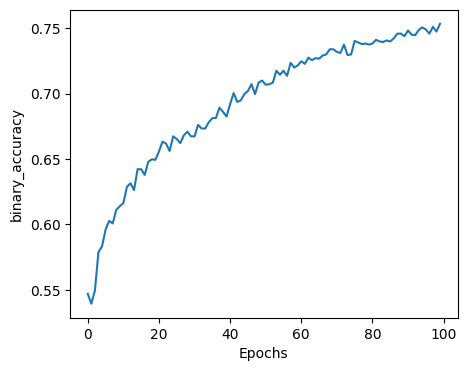

In [ ]:
# Make a plot for the accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_accuracy")

### Comparing CNN to NN Model

In [ ]:
# Load model weights

Adadelta_model.load_weights('Adadelta_model.weights.h5')
cnn_model.load_weights('cnn_model.weights.h5')

#### Comparing Results on 5 Test Images

In [ ]:
# Randomly select 5 images from the test set
indices = np.random.choice(len(X_test), 5, replace=False)
test_images = X_test[indices]
test_labels = Y_test[indices]

In [ ]:
test_images = test_images.reshape(-1, 64, 64, 3)
test_images_nn = test_images.reshape(-1, 64 * 64 * 3)


In [ ]:
# Predict the labels using the previous model and the CNN model
previous_predictions = Adadelta_model.predict(test_images_nn)
cnn_predictions = cnn_model.predict(test_images)

# Prepare the data for the table
table_data = []

for i in range(5):
    true_label = 'Fresh' if test_labels[i] == 1 else 'Rotten'
    nn_pred_label = 'Fresh' if np.argmax(previous_predictions[i]) == 1 else 'Rotten'
    cnn_pred_label = 'Fresh' if np.argmax(cnn_predictions[i]) == 1 else 'Rotten'
    table_data.append([f"Display Image {i+1}", nn_pred_label, cnn_pred_label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Image            Predicted Labels from NN model    Predicted Labels from CNN model
---------------  --------------------------------  ---------------------------------
Display Image 1  Rotten                            Rotten
Display Image 2  Rotten                            Rotten
Display Image 3  Rotten                            Rotten
Display Image 4  Rotten                            Rotten
Display Image 5  Rotten                            Rotten


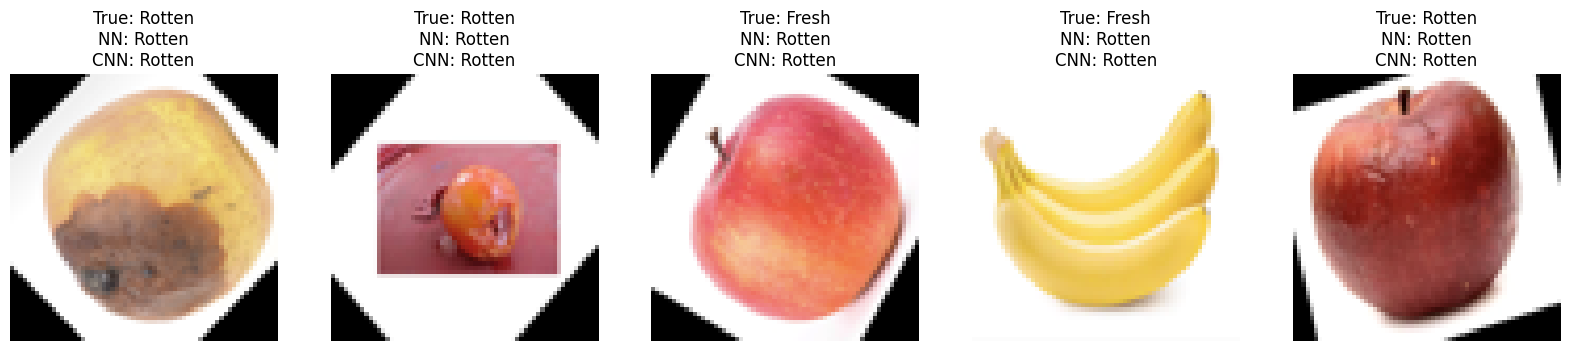

In [ ]:
# Print the table
print(tabulate(table_data, headers=["Image", "Predicted Labels from NN model", "Predicted Labels from CNN model"]))

# Display the images with their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.set_title(f"True: {'Fresh' if test_labels[i] == 1 else 'Rotten'}\nNN: {nn_pred_label}\nCNN: {cnn_pred_label}")
    ax.axis('off')
plt.show()

In [ ]:
X_test = X_test.reshape(-1, 64, 64, 3)
X_test_nn = X_test.reshape(-1, 64 * 64 * 3)

In [ ]:
# Evaluate performance
previous_loss, previous_accuracy = Adadelta_model.evaluate(X_test_nn, Y_test)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, Y_test)

print(f"Previous Model Accuracy: {previous_accuracy}")
print(f"CNN Model Accuracy: {cnn_accuracy}")

if cnn_accuracy > previous_accuracy:
    print("CNN model outperforms the previous NN model.")
else:
    print("Previous NN model outperforms the CNN model.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6965 - loss: 0.5947 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8142 - loss: 0.4164
Previous Model Accuracy: 0.7045454382896423
CNN Model Accuracy: 0.8074162602424622
CNN model outperforms the previous NN model.


### Using ResNet, MobileNet, and VGG to Predict 5 Test Images

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.preprocessing import image
from tabulate import tabulate

%pip install tensorflow_hub
import tensorflow_hub as hub


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Preprocess the images for each model
def preprocess_images_for_model(imgs, model_name):
    # Ensure images are uint8 and resize them
    resized_images = np.array([np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((224, 224))) for img in imgs])
    if model_name == 'resnet':
        return preprocess_resnet(resized_images)
    elif model_name == 'vgg':
        return preprocess_vgg(resized_images)
    elif model_name == 'mobilenet':
        return preprocess_mobilenet(resized_images)
    else:
        raise ValueError("Unknown model name")

print("Shape of test_images:", test_images.shape)
# Preprocess the images
resnet_images = preprocess_images_for_model(test_images, 'resnet')
vgg_images = preprocess_images_for_model(test_images, 'vgg')
mobilenet_images = preprocess_images_for_model(test_images, 'mobilenet')

Shape of test_images: (5, 64, 64, 3)


In [ ]:
# Function to get top-5 predictions
def get_top_5_predictions(model, img):
    preds = model.predict(img)
    top_5_indices = preds[0].argsort()[-5:][::-1]
    return top_5_indices

In [ ]:
# Load ResNet50 model
resnet_model = tf.keras.applications.ResNet50(weights='imagenet')

# Load VGG
vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')

# Load MobileNet
mobilenet_model = tf.keras.applications.MobileNet(weights='imagenet')

# Function to decode predictions into readable format
def get_top_5_predictions(model, img):
    preds = model.predict(img)
    return tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)[0]


# Top 5 predictions for each model
top_5_predictions_resnet = [get_top_5_predictions(resnet_model, np.expand_dims(img, axis=0)) for img in resnet_images]
top_5_predictions_vgg = [get_top_5_predictions(vgg_model, np.expand_dims(img, axis=0)) for img in vgg_images]
top_5_predictions_mobilenet = [get_top_5_predictions(mobilenet_model, np.expand_dims(img, axis=0)) for img in mobilenet_images]



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
# Function to map indices to class labels
def decode_predictions(preds, top=5):
    from tensorflow.keras.applications.imagenet_utils import decode_predictions
    return decode_predictions(preds, top=top)


# Record the position of the correct label within the top-5 prediction list
def get_correct_label_position(predictions, correct_label):
    # Extract just the predicted class labels
    predicted_labels = [label[1] for label in predictions]
    try:
        return predicted_labels.index(correct_label) + 1
    except ValueError:
        return -1  # If the correct label is not in the top-5 predictions


# Calculate the average rank for each model
average_rank_resnet = np.mean([get_correct_label_position(preds, test_labels[i]) for i, preds in enumerate(top_5_predictions_resnet)])
average_rank_vgg = np.mean([get_correct_label_position(preds, test_labels[i]) for i, preds in enumerate(top_5_predictions_vgg)])
average_rank_mobilenet = np.mean([get_correct_label_position(preds, test_labels[i]) for i, preds in enumerate(top_5_predictions_mobilenet)])

# Print the average ranks
print(f"Average rank for ResNet: {average_rank_resnet}")
print(f"Average rank for VGG: {average_rank_vgg}")
print(f"Average rank for MobileNet: {average_rank_mobilenet}")

# Determine which model yields the most accurate predictions
best_model = min(('ResNet', average_rank_resnet), ('VGG', average_rank_vgg), ('MobileNet', average_rank_mobilenet), key=lambda x: x[1])

print(f"The most accurate model based on the average rank is: {best_model[0]}")

Average rank for ResNet: -1.0
Average rank for VGG: -1.0
Average rank for MobileNet: -1.0
The most accurate model based on the average rank is: ResNet


Image            ResNet Top-5 Predictions                                               VGG Top-5 Predictions                                               MobileNet Top-5 Predictions
---------------  ---------------------------------------------------------------------  ------------------------------------------------------------------  ---------------------------------------------------------------------
Display Image 1  pick / spaghetti_squash / hourglass / electric_ray / butternut_squash  butternut_squash / spaghetti_squash / pick / French_loaf / spatula  spaghetti_squash / butternut_squash / consomme / potpie / French_loaf
Display Image 2  Windsor_tie / mortarboard / academic_gown / envelope / cleaver         Windsor_tie / envelope / letter_opener / cleaver / whistle          Windsor_tie / ladybug / pomegranate / orange / tick
Display Image 3  pick / strawberry / fig / lipstick / hourglass                         lipstick / matchstick / Band_Aid / pick / hourglass                 

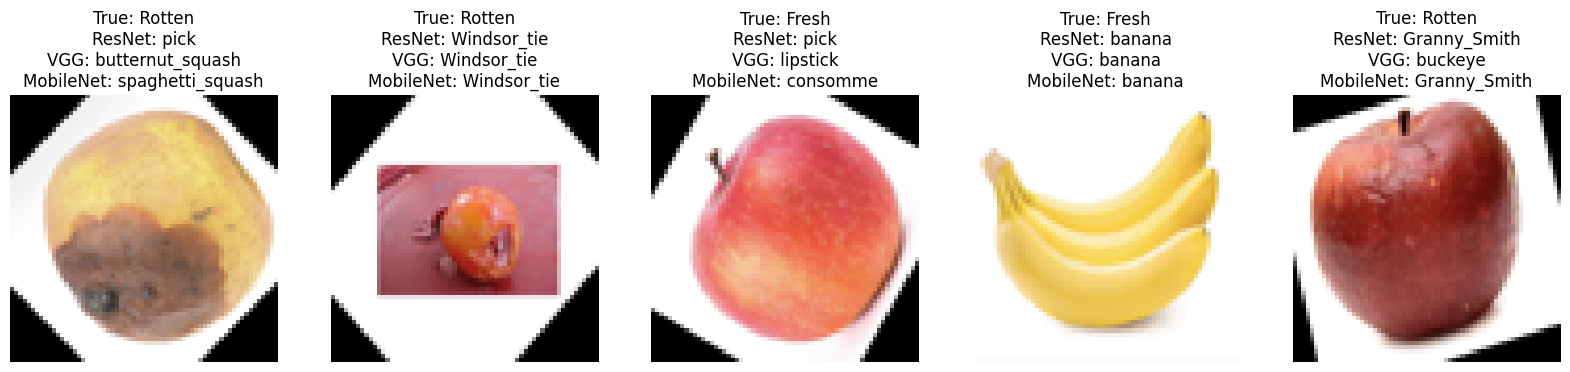

In [ ]:
# Assuming top_5_predictions_* lists contain tuples or lists of predicted classes or labels
table_data = []
for i in range(5):
    table_data.append([
        f"Display Image {i + 1}",
        ' / '.join([pred[1] for pred in top_5_predictions_resnet[i]]),  # Assuming pred[1] is the class name
        ' / '.join([pred[1] for pred in top_5_predictions_vgg[i]]),
        ' / '.join([pred[1] for pred in top_5_predictions_mobilenet[i]])
    ])


# Print the table
print(tabulate(table_data, headers=["Image", "ResNet Top-5 Predictions", "VGG Top-5 Predictions", "MobileNet Top-5 Predictions"]))

# Display the images with their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])  # Assuming images are correctly preprocessed for display
    true_label = 'Fresh' if test_labels[i] == 1 else 'Rotten'

    # Get only the top prediction (highest rank) from each model
    resnet_pred = top_5_predictions_resnet[i][0][1]  # [0] for top prediction, [1] for class name
    vgg_pred = top_5_predictions_vgg[i][0][1]
    mobilenet_pred = top_5_predictions_mobilenet[i][0][1]

    # Format the title to show only the top prediction for each model
    ax.set_title(f"True: {true_label}\nResNet: {resnet_pred}\nVGG: {vgg_pred}\nMobileNet: {mobilenet_pred}")
    ax.axis('off')
plt.show()

